In [59]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import matplotlib
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
import math
from preprocess import *
%matplotlib inline

file_name = "~/Data1030Project/data/data.xls"
df = pd.read_excel(file_name, skiprows = 1)
df = df.drop("ID", axis = 1)
# Special part - features have mixed types
mixed_features = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
for mixed_feature in mixed_features:
    for i in range(-2,1):
        df[mixed_feature + "_" + str(i)] = [1 if t else 0 for t in df[mixed_feature] == i]
        df[mixed_feature] = [0 if t == i else t for t in df[mixed_feature]]

# Label Encoder for the class variable
le = LabelEncoder()
Y = pd.DataFrame(le.fit_transform(df["default payment next month"]), columns = ["Y"])
df = df.drop("default payment next month", axis = 1)
df = pd.concat([df, Y], axis = 1)
ftr_names = df.drop("Y", axis = 1).columns

In [62]:
ftr_names.shape

(41,)

In [26]:
y = df["Y"]
X = df.drop(columns = "Y")

In [3]:
from confusionmatrix import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc

def ML_pipeline_kfold_rf(X,y,random_state,n_folds):
    
    ## Split your data in a stratified manner, 5 stratified folds.
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify = y)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    test_scores = []
    best_params = []
    best_models = []
    best_rocs = []
    y_preds = []
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)

    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other.iloc[train_index], X_other.iloc[CV_index]
        y_train, y_CV = y_other.iloc[train_index], y_other.iloc[CV_index]
        X_train.reset_index(drop=True, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        X_CV.reset_index(drop=True, inplace=True)
        y_CV.reset_index(drop=True, inplace=True)     
        
        ## Preprocessing
        X_train, sscaler, ohe, minmax = preprocess_train(X_train)
        X_c = preprocess_other(X_CV, sscaler, ohe, minmax)
        X_t = preprocess_other(X_test, sscaler, ohe, minmax)
        
        # Random Forest
        max_depth = range(1,10)
        minimum_splits = range(2,10)
        CV_f1_scores = []
        depths_splits = []
        models = []
        for d in max_depth:
            for s in minimum_splits:
                rfc = RandomForestClassifier(n_estimators=50, min_samples_split=s, max_depth=d, random_state=random_state)
                rfc.fit(X_train,y_train)
                CV_f1_scores.append(f1_score(y_CV,rfc.predict(X_c)))
                depths_splits.append((d,s))
                models.append(rfc)
                
        best_parameters = depths_splits[np.argmax(CV_f1_scores)]
        model = models[np.argmax(CV_f1_scores)]
        y_pred = model.predict(X_t)
        fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_t)[:,1])
        
        y_preds.append(y_pred)
        best_models.append(model)
        best_rocs.append((fpr, tpr, auc(fpr, tpr)))
        best_params.append(best_parameters)
        test_scores.append(accuracy_score(y_test, y_pred))       

    confusion = (y_test, y_preds[np.argmax(test_scores)])
    best_score = np.max(test_scores)
    best_param = best_params[np.argmax(test_scores)]
    best_roc = best_rocs[np.argmax(test_scores)]
    best_model = best_models[np.argmax(test_scores)]

    return best_score, best_param, confusion, best_roc, best_model

In [4]:
n_folds = 5

best_scores = []
best_params = []
best_confusion = []
best_rocs = []
best_models = []

for i in range(1,10):
    best_score, best_param, confusion, best_roc, best_model = ML_pipeline_kfold_rf(X,y,i**2,n_folds)
    best_scores.append(best_score)
    best_params.append(best_param)
    best_confusion.append(confusion)
    best_rocs.append(best_roc)
    best_models.append(best_model)
    print("Best param:", best_param, "at random state =", i**2)

best_score = np.max(best_scores)    
best_params = best_params[np.argmax(best_scores)]
confusion = best_confusion[np.argmax(best_scores)]
best_roc = best_rocs[np.argmax(best_scores)]
best_model = best_models[np.argmax(best_scores)]

Best param: (8, 3) at random state = 1
Best param: (8, 8) at random state = 4
Best param: (9, 8) at random state = 9
Best param: (9, 8) at random state = 16
Best param: (8, 8) at random state = 25
Best param: (8, 4) at random state = 36
Best param: (7, 5) at random state = 49
Best param: (9, 5) at random state = 64
Best param: (7, 2) at random state = 81


In [8]:
means = np.mean(best_scores)
std = np.std(best_scores)
print("Best score", best_score, " Best params", best_params)
print("The accuracy has mean", means, "and std", std)

Best score 0.8271666666666667  Best params (8, 4)
The accuracy has mean 0.8214259259259259 and std 0.0031002898222855456


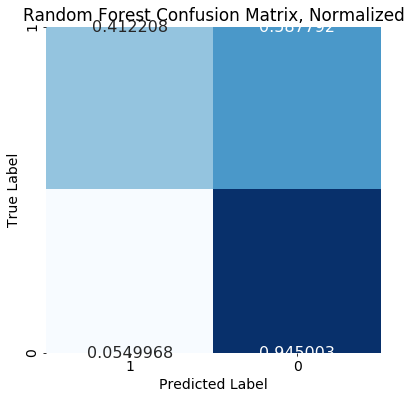

In [81]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(confusion[0], confusion[1])
logistics_cm = {'DR': 0, 'FAR': 0, 'FNR': 0, 'TNR':0}
DR = cm[1,1]
FAR = cm[0,1]
FNR = cm[1,0]
TNR = cm[0,0]
logistics_cm['DR'] += DR
logistics_cm['FAR'] += FAR
logistics_cm['FNR'] += FNR
logistics_cm['TNR'] += TNR

# plot confusion matrix
import seaborn as sns
log_cm_df = pd.DataFrame([[logistics_cm['DR'],logistics_cm['FNR']],
                          [logistics_cm['FAR'], logistics_cm['TNR']]], index=[1, 0], columns = [1, 0])
log_cm_df1 = log_cm_df.astype('float') / log_cm_df.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (6,6))
plt.title("Random Forest Confusion Matrix, Normalized")
sns.heatmap(log_cm_df1, annot=True, fmt='g', cbar=False, 
           annot_kws={"size": 16}, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('../figures/confusion_matrix_rf.png',dpi=300)
plt.show()

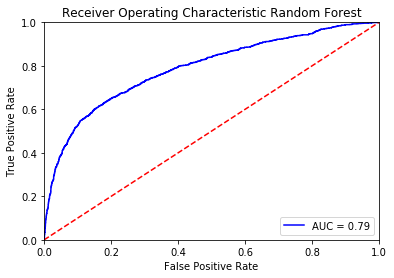

In [25]:
plt.plot(best_roc[0], best_roc[1], 'b', label = 'AUC = %0.2f' % best_roc[2])
plt.title('Receiver Operating Characteristic Random Forest')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('../figures/roc_rf.png',dpi=300)
plt.show()

In [65]:
nr_runs = 10
scores = np.zeros([len(ftr_names), nr_runs])
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = 36, stratify = y)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_test_copy, sscaler, ohe, minmax = preprocess_train(X_test.copy())

test_score = best_model.score(X_test_copy,y_test)

print('test score = ', test_score)
print('test baseline = ', np.sum(y_test == 0)/len(y_test))

# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        X_test_shuffled, sscaler, ohe, minmax = preprocess_train(X_test_shuffled)
        acc_scores.append(best_model.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8271666666666667
test baseline =  0.7788333333333334
shuffling LIMIT_BAL
   shuffled test score: 0.825 +/- 0.001
shuffling SEX
   shuffled test score: 0.826 +/- 0.001
shuffling EDUCATION
   shuffled test score: 0.826 +/- 0.0
shuffling MARRIAGE
   shuffled test score: 0.826 +/- 0.0
shuffling AGE
   shuffled test score: 0.827 +/- 0.0
shuffling PAY_0
   shuffled test score: 0.804 +/- 0.002
shuffling PAY_2
   shuffled test score: 0.824 +/- 0.0
shuffling PAY_3
   shuffled test score: 0.826 +/- 0.0
shuffling PAY_4
   shuffled test score: 0.825 +/- 0.0
shuffling PAY_5
   shuffled test score: 0.826 +/- 0.0
shuffling PAY_6
   shuffled test score: 0.823 +/- 0.0
shuffling BILL_AMT1
   shuffled test score: 0.822 +/- 0.001
shuffling BILL_AMT2
   shuffled test score: 0.826 +/- 0.001
shuffling BILL_AMT3
   shuffled test score: 0.826 +/- 0.001
shuffling BILL_AMT4
   shuffled test score: 0.826 +/- 0.0
shuffling BILL_AMT5
   shuffled test score: 0.826 +/- 0.001
shuffling BILL_AMT6
   shu

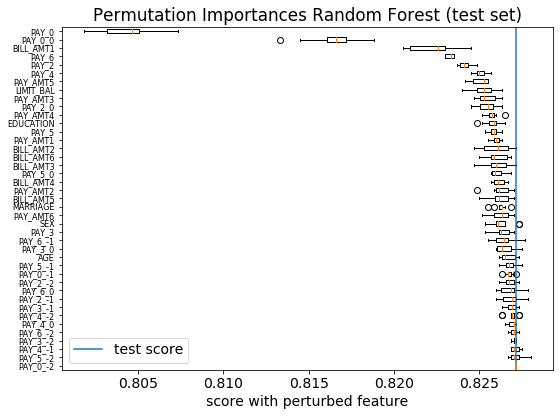

In [82]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances Random Forest (test set)")
plt.xlabel('score with perturbed feature')
plt.legend(loc = 3)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('../figures/feature_importance_rf.png',dpi=300)
plt.show()